In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'1.2.1'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST", one_hot=True)

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print(f"Train set: {len(data.train.labels)}")
print(f"Test set: {len(data.test.labels)}")
print(f"Valid set: {len(data.validation.labels)}")

Size of:
Train set: 55000
Test set: 10000
Valid set: 5000


In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

### Data dimesions

In [8]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for  i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = f"True: {cls_true[i]}"
        else:
            xlabel = f"True: {cls_true[i]}, Pred: {cls_pred[i]}"
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

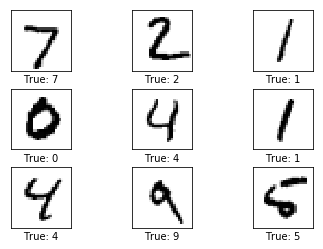

In [10]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)

## Tensor flow

In [11]:
# placeholders (inputs)
x = tf.placeholder(tf.float32, [None, img_size_flat])

y_true = tf.placeholder(tf.float32, [None, num_classes])

y_true_cls = tf.placeholder(tf.int64, [None])

# parameters
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

biases = tf.Variable(tf.zeros([num_classes]))

In [12]:
logits = tf.matmul(x, weights) + biases

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)

cost = tf.reduce_mean(cross_entropy)

In [14]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

In [15]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow session

In [16]:
session = tf.Session()

In [17]:
session.run(tf.global_variables_initializer())

In [18]:
batch_size = 100

In [19]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)

In [20]:
feed_dict_test = {x: data.test.images, 
                 y_true: data.test.labels,
                 y_true_cls: data.test.cls}

In [21]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    print(f"Accuracy on test-set: {acc * 100}")

In [22]:
def print_confusion_matrix():
    cls_true = data.test.cls
    
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

In [23]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                   feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]
   
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [24]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Pre-optim

In [25]:
print_accuracy()

Accuracy on test-set: 9.799999743700027


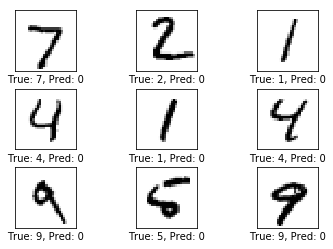

In [26]:
plot_example_errors()

## 1 iter

In [27]:
optimize(num_iterations=1)

In [28]:
print_accuracy()

Accuracy on test-set: 23.980000615119934


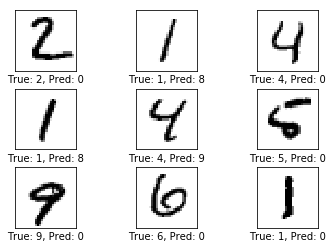

In [29]:
plot_example_errors()

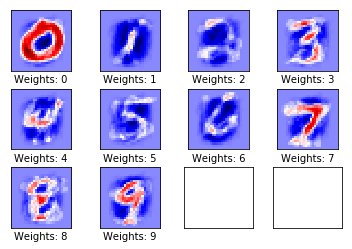

In [30]:
plot_weights()

In [31]:
optimize(num_iterations=9)

In [32]:
print_accuracy()

Accuracy on test-set: 71.60999774932861


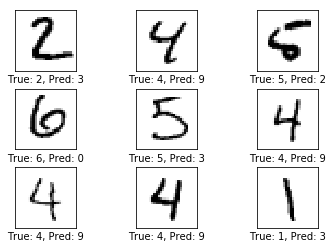

In [33]:
plot_example_errors()

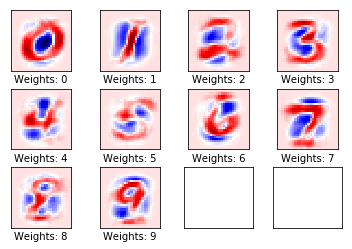

In [34]:
plot_weights()

In [35]:
optimize(num_iterations=990)

In [36]:
print_accuracy()

Accuracy on test-set: 90.96999764442444


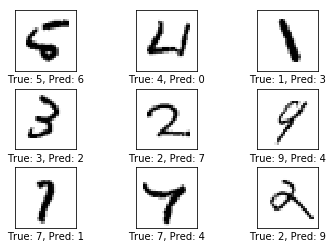

In [37]:
plot_example_errors()

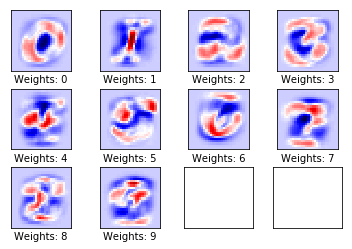

In [38]:
plot_weights()

[[ 966    0    1    2    1    2    4    1    3    0]
 [   0 1102    2    3    1    2    4    1   20    0]
 [  10    9  893   22   16    1   14   18   43    6]
 [   4    1   15  922    1   20    3   12   23    9]
 [   2    5    6    1  911    0    9    1   10   37]
 [  12    4    5   50   11  734   16   11   41    8]
 [  19    3    4    3   13   15  894    1    6    0]
 [   5   18   25    7    8    0    0  928    3   34]
 [   8    9    7   29    8   20   11   11  862    9]
 [  11    9    5   13   48    8    0   21    9  885]]


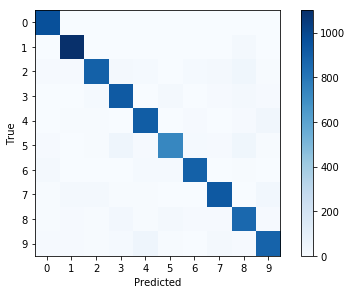

In [39]:
print_confusion_matrix()

In [42]:
optimize(num_iterations=9000)

In [43]:
print_accuracy()

Accuracy on test-set: 92.39000082015991
